# Preprocesamiento

In [8]:
import pandas as pd
import folium
import requests
import time
# Cargamos el dataset
df = pd.read_csv("./CTU13/concatenado.csv")
df.head()
df.shape

(8716226, 15)

In [ ]:
# Visualizacion de las columnas con registro de Botnet:
print("Registros que corresponden a ataques:")
print(df[df['Label'].str.contains('Botnet')].shape[0])
print("Registros que corresponden a tráfico normal:")
print(df[df['Label'].str.contains('Botnet') == False].shape[0])

Registros que corresponden a ataques:
339700
Registros que corresponden a tráfico normal:
8376526


In [9]:
dfmod = df #Crear una copia del dataframe original para su modificacion
# Crear una nueva columna evaluando si "botnet" está en la columna "label"
dfmod["is_botnet"] = dfmod["Label"].astype(str).apply(lambda x: 1 if "botnet" in x.lower() else 0)

In [10]:
dfmod.sample(5, random_state=402)

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,is_botnet
8673270,2011/08/19 11:35:22.936759,2.132038,udp,147.32.84.229,13363,<->,84.228.161.252,13786,CON,0.0,0.0,3,639,152,flow=Background-UDP-Established,0
7021361,2011/08/17 17:04:05.470661,0.010079,udp,147.32.84.191,4599,<->,147.32.80.9,53,CON,0.0,0.0,2,345,69,flow=From-Botnet-V50-2-UDP-DNS,1
8172170,2011/08/18 14:23:12.261800,0.000761,udp,95.54.180.148,46730,<->,147.32.84.229,13363,CON,0.0,0.0,2,134,74,flow=Background-UDP-Established,0
8073619,2011/08/18 14:03:29.598921,0.000893,udp,79.100.53.124,9039,<->,147.32.84.229,13363,CON,0.0,0.0,2,130,70,flow=Background-UDP-Established,0
6767597,2011/08/17 16:31:57.846932,73.615273,tcp,147.32.86.122,47249,->,94.127.76.130,80,FSPA_FSPA,0.0,0.0,119,110670,4289,flow=Background-TCP-Established,0


(339700, 16)
SrcAddr
147.32.84.165      79371
147.32.84.192      31272
147.32.84.191      29994
147.32.84.204      29942
147.32.84.206      29840
147.32.84.205      29409
147.32.84.208      29027
147.32.84.193      27970
147.32.84.207      26580
147.32.84.209      26270
222.160.227.154        5
95.65.17.47            4
91.188.37.153          4
69.104.66.134          4
161.200.133.204        4
93.103.254.175         4
Name: count, dtype: int64


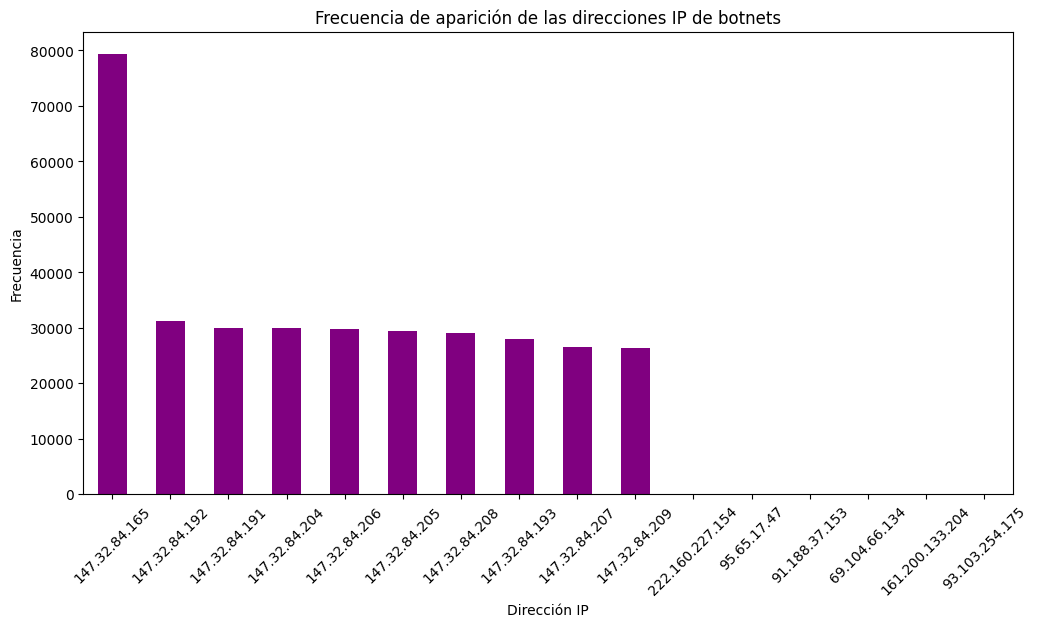

['147.32.84.165' '147.32.84.191' '147.32.84.192' '147.32.84.193'
 '147.32.84.204' '147.32.84.205' '147.32.84.206' '147.32.84.207'
 '147.32.84.208' '147.32.84.209' '95.65.17.47' '91.188.37.153'
 '69.104.66.134' '161.200.133.204' '222.160.227.154' '93.103.254.175']
Mapa generado: mapa_ips_botnet.html


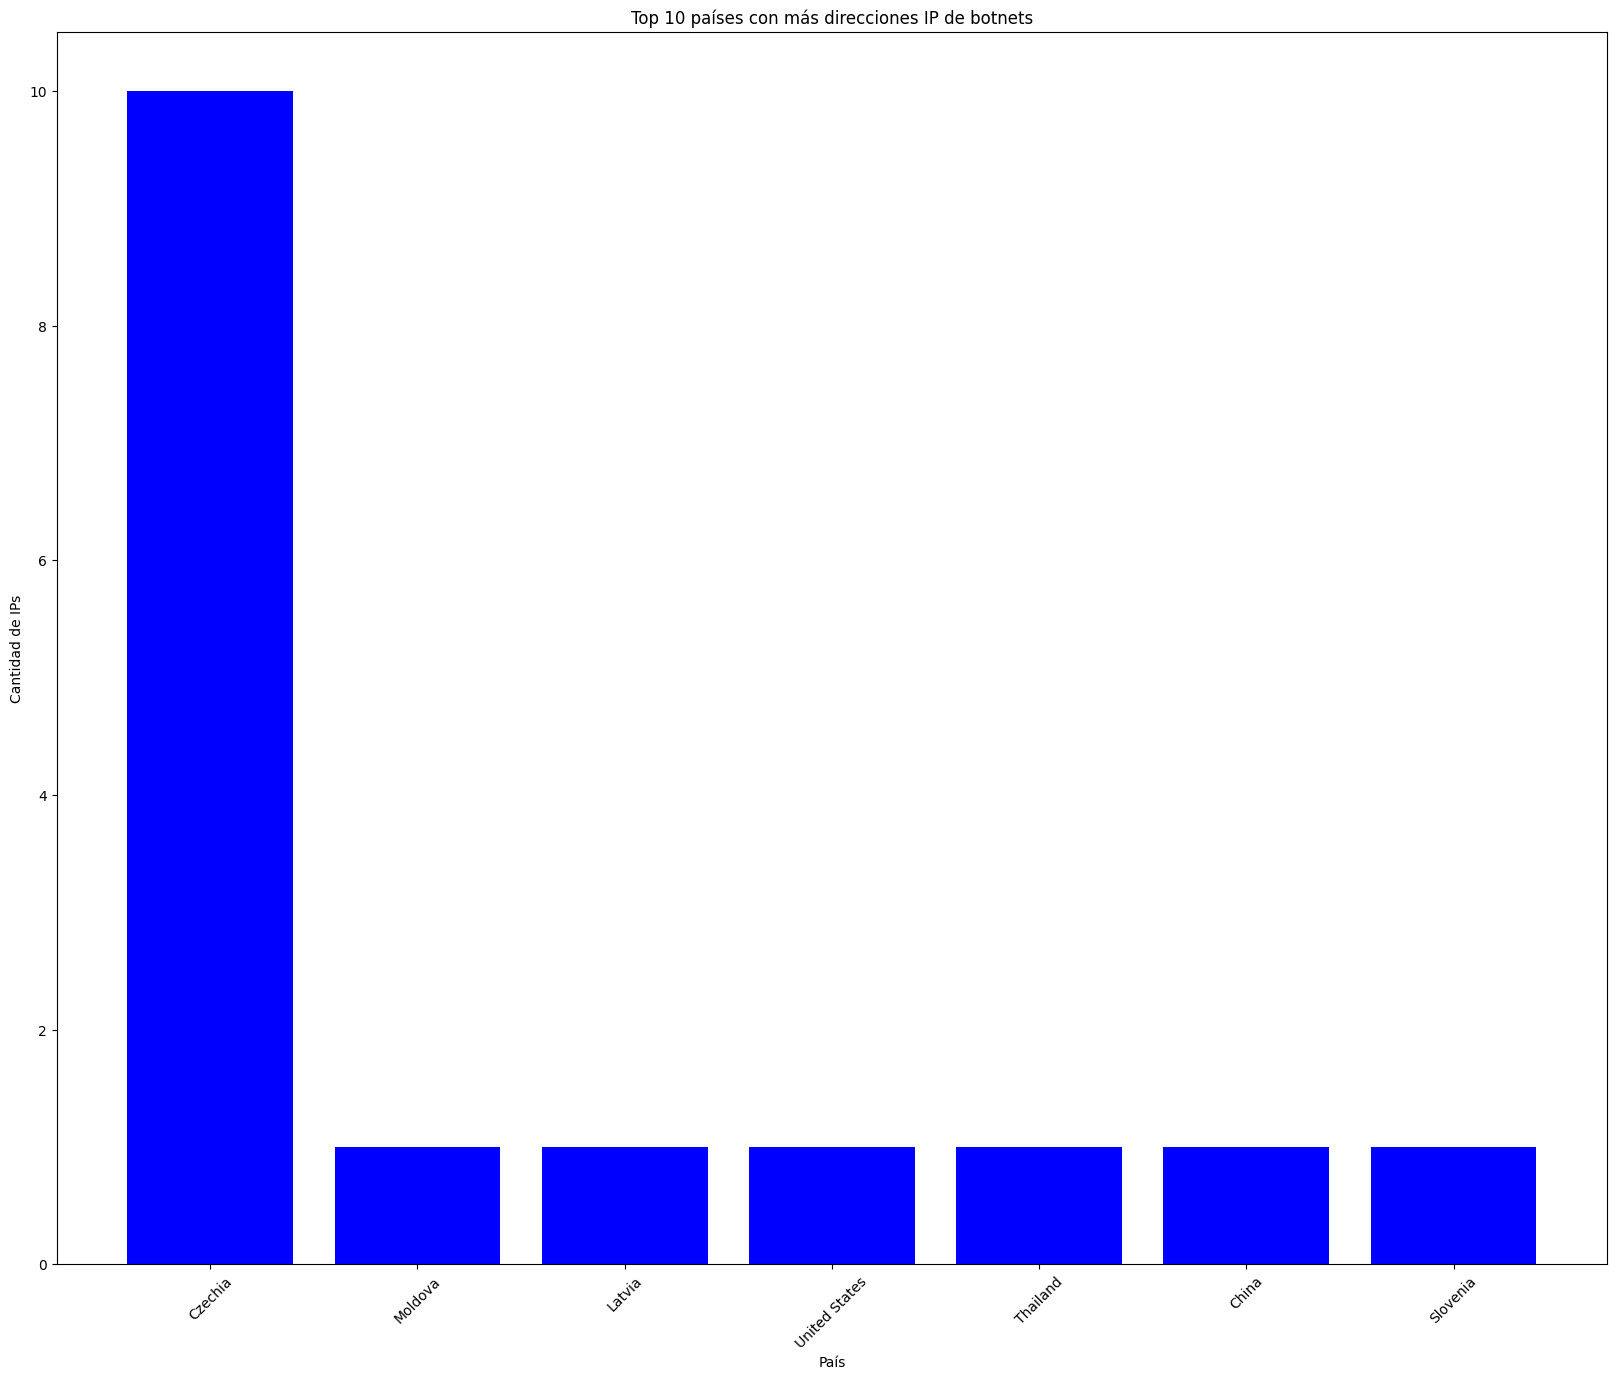

In [13]:

import matplotlib.pyplot as plt


# Filtrar solo las direcciones IP de botnets
df_botnet = dfmod[dfmod["is_botnet"] == 1]
print(df_botnet.shape)

# Contar la cantidad de veces que se repite cada IP en el dataframe
ip_counts = df_botnet["SrcAddr"].value_counts()
print(ip_counts)

# Graficar la frecuencia de aparición de las IPs
plt.figure(figsize=(12, 6))
ip_counts[:20].plot(kind="bar", color="purple")  # Mostrar solo las 20 más frecuentes para mejor visualización
plt.xlabel("Dirección IP")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de aparición de las direcciones IP de botnets")
plt.xticks(rotation=45)
plt.show()
# Tomar una muestra de 1000 registros para optimizar

#df_botnet = df_botnet.sample(150000, random_state=500)

# Extraer IPs únicas de la columna SrcAddr
unique_ips = df_botnet["SrcAddr"].unique()
print(unique_ips)

# Función para obtener geolocalización de IP con ip-api.com
def get_location(ip):
    url = f"http://ip-api.com/json/{ip}?fields=status,lat,lon,country,city"
    try:
        response = requests.get(url)
        data = response.json()
        if data["status"] == "success":
            return data["lat"], data["lon"], data["country"], data["city"]
    except Exception as e:
        print(f"Error con IP {ip}: {e}")
    return None

# Obtener geolocalización de cada IP (con retraso para evitar bloqueo de API)
ip_locations = {}
for ip in unique_ips:
    location = get_location(ip)
    if location:
        ip_locations[ip] = location
    time.sleep(1)  # Evitar bloqueos por exceso de peticiones

# Crear un mapa centrado en el mundo
m = folium.Map(location=[20, 0], zoom_start=2)

# Contar países
country_counts = {}

# Añadir puntos al mapa
for ip, (lat, lon, country, city) in ip_locations.items():
    folium.Marker(
        location=[lat, lon],
        popup=f"{ip}\n{city}, {country}",
        icon=folium.Icon(color="red")
    ).add_to(m)
    
    if country in country_counts:
        country_counts[country] += 1
    else:
        country_counts[country] = 1

# Guardar el mapa en un archivo HTML
m.save("mapa_ips_botnet.html")
print("Mapa generado: mapa_ips_botnet.html")

# Graficar los países con más direcciones IP
sorted_countries = sorted(country_counts.items(), key=lambda x: x[1], reverse=True)[:10]
countries, counts = zip(*sorted_countries)

plt.figure(figsize=(20, 16))
plt.bar(countries, counts, color='blue')
plt.xlabel("País")
plt.ylabel("Cantidad de IPs")
plt.title("Top 10 países con más direcciones IP de botnets")
plt.xticks(rotation=45)
plt.show()